# 用OpenCV实现的图片DFT示例

尽管我知道Python有很多方便的FFT库，但是为了方便学习C/C++的朋友，我尽量用原生的OpenCV库做完了这个用例。理论的那一套在前面的一维FFT里已经讲过，所以这里不赘述，直接上完整的代码好了。

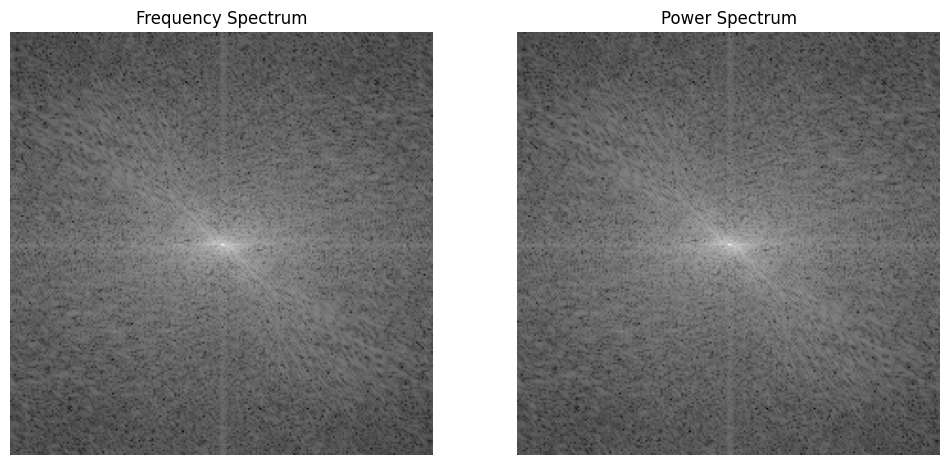

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


def shift_spectrum(gamma_matrix):
	# 和C++语言的OpenCV库中获取矩阵大小方式类似
	# 可以用如下方法获得
	# int rows = gamma_matrix.rows
	# int cols = gamma_matrix.cols

    # 中心化
    rows, cols = gamma_matrix.shape
    if rows % 2 != 0 or cols % 2 != 0:
        gamma_matrix = gamma_matrix[:rows - rows % 2, :cols - cols % 2]
    
    rows, cols = gamma_matrix.shape
    cr, cc = rows // 2, cols // 2

	# 计算四个象限子矩阵
	# 可以使用C/C++中通常使用 Rect 来获取原矩阵的四个象限范围
	# (0,0)----------------------------->cols
	# Q2             | Q1                 |
	# (0r,0c)        |                    |  
	#                |(cr,cc)             |
	# ---------------|------------------- |
	# Q3             | Q4                 |
	#                |                    |
	#                |                    |
	#                                    (rows,cols)	
	
    # 交换象限
    top_left = gamma_matrix[0:cr, 0:cc]
    top_right = gamma_matrix[0:cr, cc:cols]
    bottom_left = gamma_matrix[cr:rows, 0:cc]
    bottom_right = gamma_matrix[cr:rows, cc:cols]

    # 生成新的中心化频谱矩阵
    shifted_matrix = np.zeros(gamma_matrix.shape, dtype=gamma_matrix.dtype)
    shifted_matrix[0:cr, 0:cc] = bottom_right
    shifted_matrix[0:cr, cc:cols] = bottom_left
    shifted_matrix[cr:rows, 0:cc] = top_right
    shifted_matrix[cr:rows, cc:cols] = top_left

    return shifted_matrix


def gen_spectrum(real_matrix, imag_matrix):
    # 生成频谱并进行 gamma 调整
    gamma_matrix = cv2.magnitude(real_matrix, imag_matrix)
    gamma_matrix = np.log(gamma_matrix + 1)

    # 归一化频谱
    normalized_spectrum = np.zeros_like(gamma_matrix, dtype=np.float32)
    cv2.normalize(gamma_matrix, normalized_spectrum, 0, 1, cv2.NORM_MINMAX)

    return normalized_spectrum


def do_fft(image_path):
    # 读取灰度图像
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    rows, cols = img.shape

    # 对尺寸进行优化，使其符合 FFT 要求的尺寸
    m, n = cv2.getOptimalDFTSize(rows), cv2.getOptimalDFTSize(cols)
    padded_img = np.zeros((m, n), dtype=np.float32)
    padded_img[:rows, :cols] = img

    # 执行傅里叶变换
    dft_result = cv2.dft(padded_img, flags=cv2.DFT_COMPLEX_OUTPUT)
    real_part, imag_part = cv2.split(dft_result)

    # 生成频谱图
    spectrum = gen_spectrum(real_part, imag_part)
    spectrum_shifted = shift_spectrum(spectrum)

    # 计算功率谱
    power_spectrum = np.square(real_part) + np.square(imag_part)
    power_spectrum_log = np.log(power_spectrum + 1)
    power_spectrum_shifted = shift_spectrum(power_spectrum_log)

    return spectrum_shifted, power_spectrum_shifted


def plot_fft_spectrums(spectrum, power_spectrum):
    # 绘制频谱图和功率谱图
    plt.figure(figsize=(12, 6))

    plt.subplot(121)
    plt.title("Frequency Spectrum")
    plt.imshow(spectrum, cmap='gray')
    plt.axis('off')

    plt.subplot(122)
    plt.title("Power Spectrum")
    plt.imshow(power_spectrum, cmap='gray')
    plt.axis('off')

    plt.show()


# 设置图像路径
image_path = "/opt/images/lena.png"

# 计算频谱图和功率谱图
spectrum_shifted, power_spectrum_shifted = do_fft(image_path)

# 绘制频谱图和功率谱图
plot_fft_spectrums(spectrum_shifted, power_spectrum_shifted)

## 正向 DFT 或 FFT 变换以及逆变换


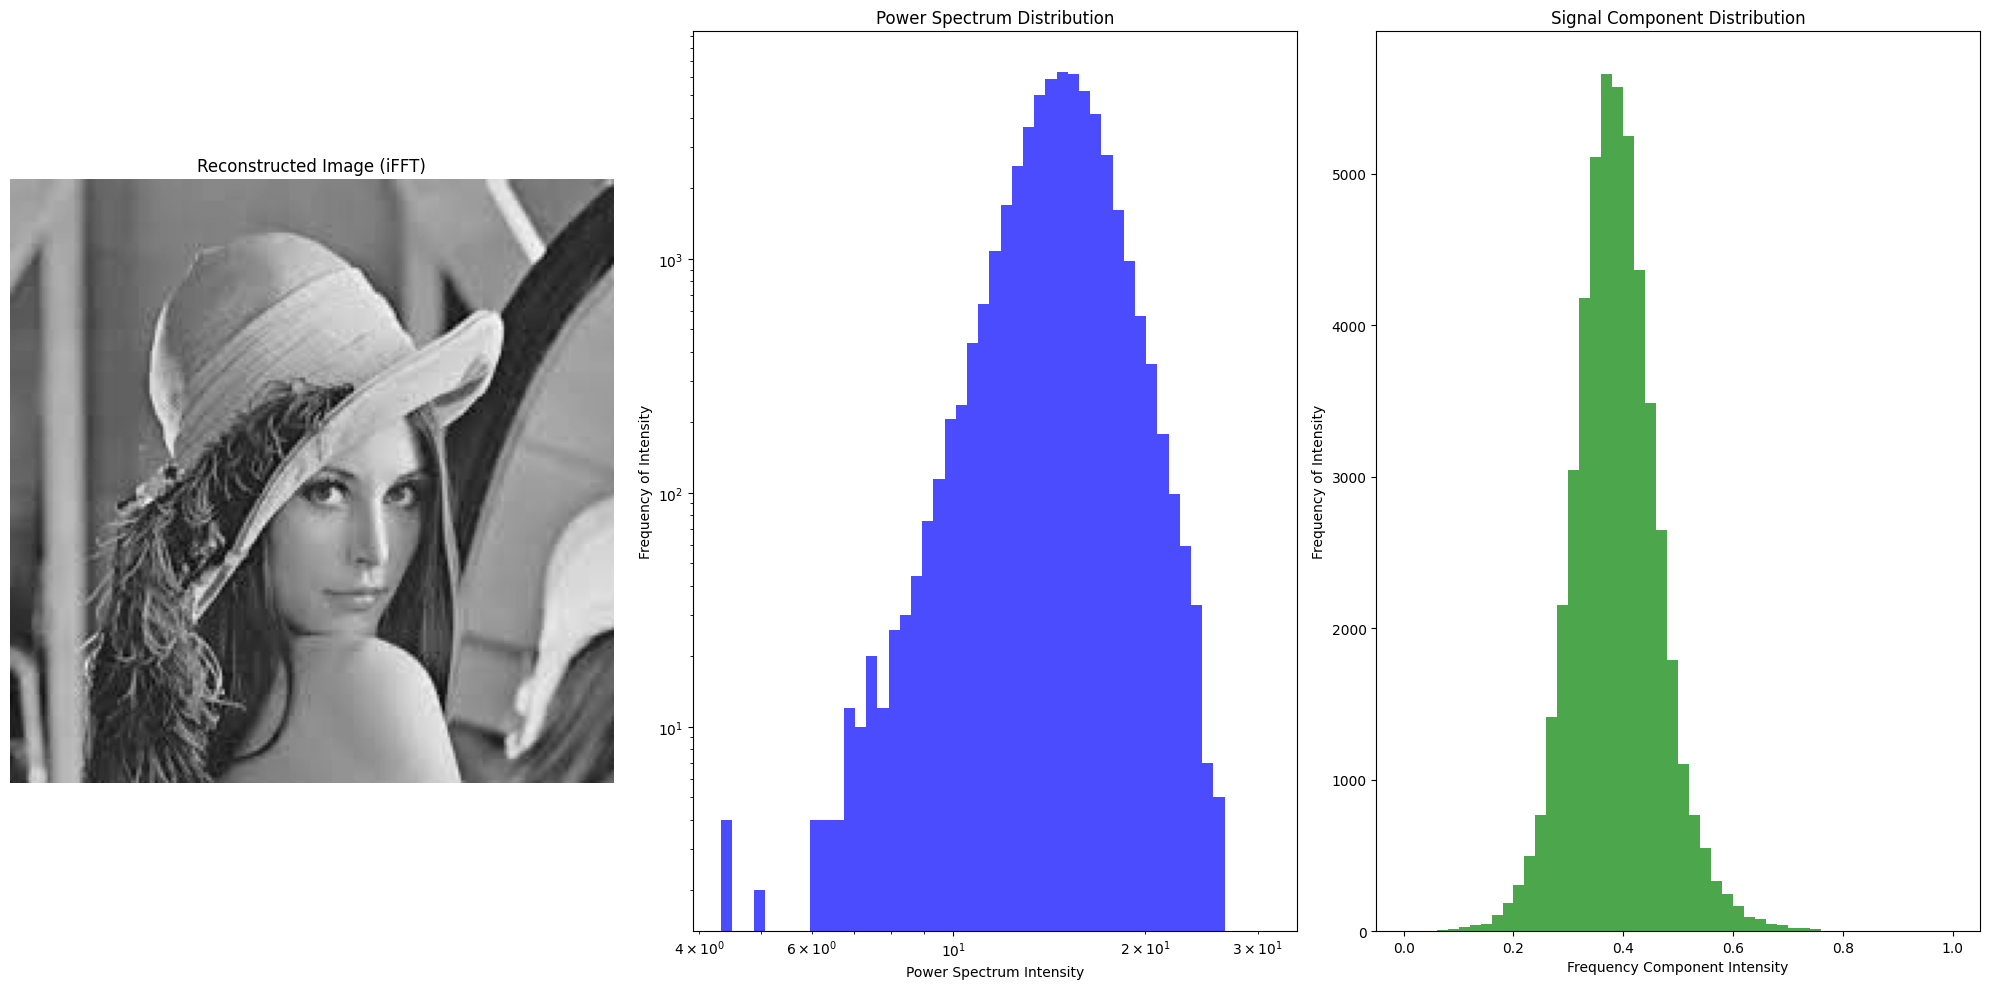

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def do_fft(image_path):
    # 读取灰度图像
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    rows, cols = img.shape

    # 对尺寸进行优化，使其符合 FFT 要求的尺寸
    m, n = cv2.getOptimalDFTSize(rows), cv2.getOptimalDFTSize(cols)
    padded_img = np.zeros((m, n), dtype=np.float32)
    padded_img[:rows, :cols] = img

    # 执行傅里叶变换
    dft_result = cv2.dft(padded_img, flags=cv2.DFT_COMPLEX_OUTPUT)
    real_part, imag_part = cv2.split(dft_result)

    # 生成频谱图
    spectrum = gen_spectrum(real_part, imag_part)
    spectrum_shifted = shift_spectrum(spectrum)

    # 计算功率谱
    power_spectrum = np.square(real_part) + np.square(imag_part)
    power_spectrum_log = np.log(power_spectrum + 1)
    power_spectrum_shifted = shift_spectrum(power_spectrum_log)

    return dft_result, spectrum_shifted, power_spectrum_shifted

def do_ifft(dft_result):
    # 计算逆傅里叶变换并恢复图像
    img_back = cv2.idft(dft_result)
    img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

    # 归一化恢复图像
    cv2.normalize(img_back, img_back, 0, 1, cv2.NORM_MINMAX)

    return img_back

def plot_all(spectrum, power_spectrum, reconstructed_img):
    # 展平频谱图数据
    signal_values = spectrum.flatten()
    signal_values = signal_values[signal_values > 0]  # 去除零值

    # 统计功率分量分布
    power_values = power_spectrum.flatten()
    power_values = power_values[power_values > 0]  # 去除零功率项
    bins = np.logspace(np.log10(power_values.min()), np.log10(power_values.max()), 50)

    # 创建一个窗口，包含3个子图
    plt.figure(figsize=(20, 10))

    # 绘制恢复的图像
    plt.subplot(131)
    plt.title("Reconstructed Image (iFFT)")
    plt.imshow(reconstructed_img, cmap='gray')
    plt.axis('off')

    # 绘制功率分布的柱状图
    plt.subplot(132)
    plt.hist(power_values, bins=bins, color='blue', alpha=0.7)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Power Spectrum Intensity")
    plt.ylabel("Frequency of Intensity")
    plt.title("Power Spectrum Distribution")

    # 绘制信号分布的柱状图
    plt.subplot(133)
    plt.hist(signal_values, bins=50, color='green', alpha=0.7)
    plt.xlabel("Frequency Component Intensity")
    plt.ylabel("Frequency of Intensity")
    plt.title("Signal Component Distribution")

    plt.tight_layout()
    plt.show()

# 设置图像路径
image_path = "/opt/images/lena.png"

# 计算频谱图和功率谱图
dft_result, spectrum_shifted, power_spectrum_shifted = do_fft(image_path)

# 执行逆傅里叶变换
reconstructed_img = do_ifft(dft_result)

# 绘制所有图在一个窗口中
plot_all(spectrum_shifted, power_spectrum_shifted, reconstructed_img)

这里你会发现转换回来的照片多了一圈黑色的边框，那个就是为了进行DFT运算，而调整的新图片大小，长宽大小都是 $2^n$。

通常，在做完FFT运算后，它输出的结果是对称的，对于2维的也是这样，不做任何处理的频率图，频率范围从四边角到中央逐渐递增，所以为了方便观察，会把四个象限的子矩阵做一下调整。

所以最终的图片也就成了从中央一个点向四周呈现放射状的形式。因此频率范围的调整就变成了计算圆半径R的问题。

通常，我们为了过滤图片中的一些信息，就会使用一些滤波器，下面介绍一些比较常用的频域滤波器。